In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

In [0]:
%cd /content/drive/My\ Drive/AutoEncoders/

In [0]:
import os
from matplotlib import pyplot as plt
from math import floor
import seaborn as sns
import pandas as pd
import numpy as np
import random
from scipy import ndarray      # n-dimensional Array
import skimage as sk           # used for image Processing
from skimage import transform
from skimage import util
import warnings
import keras
warnings.filterwarnings('ignore')  # remove the warnings
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from keras.regularizers import l2,l1 # for model
from keras.layers import Input,Conv2D,Dense, Dropout, BatchNormalization, MaxPooling2D, Activation, Flatten, AvgPool2D,InputLayer,GlobalAveragePooling2D,UpSampling2D
from keras.layers import  BatchNormalization as btn
from keras.layers import Lambda
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras.callbacks import LearningRateScheduler   
from IPython.display import HTML
import base64
from keras import backend as K
from keras.optimizers import RMSprop
from scipy.ndimage.interpolation import shift
from keras.optimizers import Adam
from keras.datasets import cifar10
from xgboost import XGBClassifier
from keras.losses import mse, binary_crossentropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import cv2 as cv
import math

%matplotlib inline

In [0]:
(X_train,y_train), (X_test,y_test) = mnist.load_data()

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, test_size=0.1)

In [7]:
print("Shape of X_train:  ",X_train.shape)
print("Shape of y_train:  ",y_train.shape)
print("="*40)
print("Shape of X_val:  ",X_val.shape)
print("Shape of y_val:  ",y_val.shape)
print("="*40)
print("Shape of X_test:  ",X_test.shape)
print("Shape of y_test:  ",y_test.shape)

Shape of X_train:   (54000, 28, 28)
Shape of y_train:   (54000,)
Shape of X_val:   (6000, 28, 28)
Shape of y_val:   (6000,)
Shape of X_test:   (10000, 28, 28)
Shape of y_test:   (10000,)


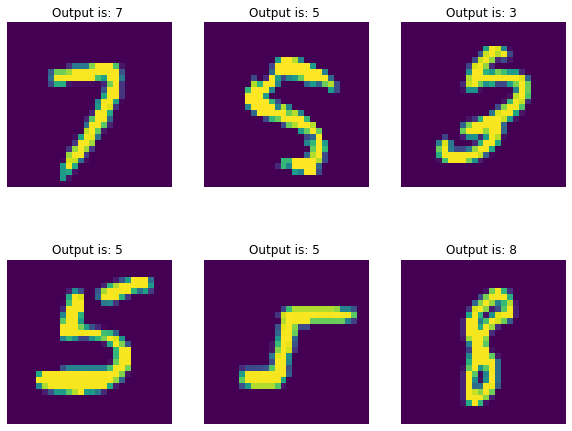

In [8]:
# visulaization of Denoised Image
plt.figure(figsize=(10,8))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(X_train[i])
  plt.title(f"Output is: {y_train[i]} ")
  plt.axis('off')

In [9]:
X_train = X_train.astype('float32')/255.0
X_val = X_val.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

X_train = np.reshape(X_train, newshape=(len(X_train),784))
X_val = np.reshape(X_val, newshape=(len(X_val),784))
X_test = np.reshape(X_test, newshape=(len(X_test),784))

print(f'Shape of X_train:  ',X_train.shape)
print(f'Shape of X_val:  ',X_val.shape)
print(f'Shape of X_test: ',X_test.shape)

Shape of X_train:   (54000, 784)
Shape of X_val:   (6000, 784)
Shape of X_test:  (10000, 784)


# **Variational AutoEncoder**

![alt text](https://iq.opengenus.org/content/images/2019/07/a6.png)

In [0]:
# designinig of Encoder.

input_image = Input(shape=(784,))
encoder = Dense(512, activation='relu')(input_image)
encoder = Dense(256, activation='relu')(encoder)
z_mean = Dense(2, name='z_mean')(encoder)
z_log_var = Dense(2, name='z_log_var')(encoder)


In [91]:
print(K.shape(z_mean)[0])
print(K.int_shape(z_mean)[1])

Tensor("strided_slice_3:0", shape=(), dtype=int32)
2


In [0]:
def sampling(arguments):

  z_mean, z_log_var = arguments
  batch = K.shape(z_mean)[0]
  dim = K.int_shape(z_mean)[1]            # 2 here.
  epsilon = K.random_normal(shape=(batch,dim), mean=0.0, stddev=1.0)
  latent_vect = z_mean + K.exp(0.5 * z_log_var) * epsilon
  
  return latent_vect

In [93]:
z = Lambda(sampling, output_shape=(2,), name='z')([z_mean, z_log_var])         # responsibe for wraping the sampling function into keras layers
print(z)
print(type(z))

Tensor("z_3/add_1:0", shape=(None, 2), dtype=float32)
<class 'tensorflow.python.framework.ops.Tensor'>


In [0]:
encoder_model = Model(input_image, [z_mean, z_log_var, z], name='encoder')             # wrap the encoder model using Model

# Input is input image
# output is the list if z_mean, z_log_var and z

In [95]:
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 512)          401920      input_7[0][0]                    
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 256)          131328      dense_15[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            514         dense_16[0][0]                   
____________________________________________________________________________________________

In [0]:
# formation of decoder

# latent_inputs = Input(shape=(2,),name='latent_inputs')
decoder = Dense(512, activation='relu')
decoder = Dense(256, activation='relu')
output_1 = Dense(784, activation='sigmoid')

h_decoder = decoder(z)
x_decoded_mean = output_1(h_decoder)


In [0]:
final_model = Model(input_image, x_decoded_mean)

In [98]:
final_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 512)          401920      input_7[0][0]                    
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 256)          131328      dense_15[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            514         dense_16[0][0]                   
____________________________________________________________________________________________

In [0]:
# wrapping the decoder models
decoder_input = Input(shape=(2,))
decoder_dense1 = decoder(decoder_input)
decoder_output = output_1(decoder_dense1)

decoder_model = Model(decoder_input, decoder_output, name='decoder')           # wrapping the decoder model.

In [100]:
decoder_model.summary()                     # it is basically generator.

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               768       
_________________________________________________________________
dense_19 (Dense)             (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


In [0]:
# In var_autoencoder there are 2 losses.
# 1--> first loss is between output image and input iamge as it has in other simple autoencoders.
# 2--> second loss is the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term.

def vae_loss(input_image,x_decoded_mean):
    xent_loss = binary_crossentropy(input_image, x_decoded_mean) * 784
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    
    return K.mean(xent_loss + kl_loss)
    

In [0]:
final_model.compile(optimizer='RMSprop', loss=vae_loss, metrics=['accuracy'])

In [103]:
history = final_model.fit(X_train,X_train, batch_size=64, epochs=20, validation_data=(X_val, X_val))

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 3s 64us/step - loss: 185.7890 - accuracy: 0.0170 - val_loss: 169.7758 - val_accuracy: 0.0113
Epoch 2/20
54000/54000 [==============================] - 4s 68us/step - loss: 168.0234 - accuracy: 0.0155 - val_loss: 164.9882 - val_accuracy: 0.0137
Epoch 3/20
54000/54000 [==============================] - 3s 61us/step - loss: 164.4186 - accuracy: 0.0148 - val_loss: 162.2215 - val_accuracy: 0.0152
Epoch 4/20
54000/54000 [==============================] - 3s 62us/step - loss: 161.6542 - accuracy: 0.0142 - val_loss: 159.5724 - val_accuracy: 0.0180
Epoch 5/20
54000/54000 [==============================] - 3s 61us/step - loss: 159.4144 - accuracy: 0.0138 - val_loss: 157.7845 - val_accuracy: 0.0095
Epoch 6/20
54000/54000 [==============================] - 3s 61us/step - loss: 157.7355 - accuracy: 0.0129 - val_loss: 156.1941 - val_accuracy: 0.0167
Epoch 7/20
54000/54000 [=====================

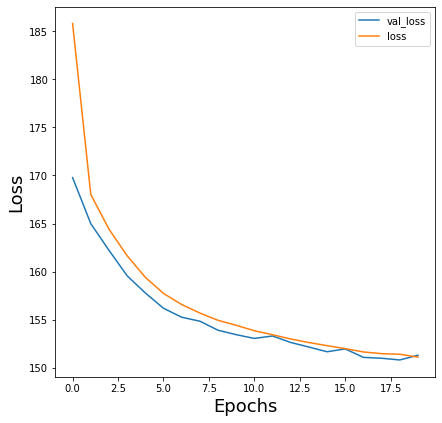

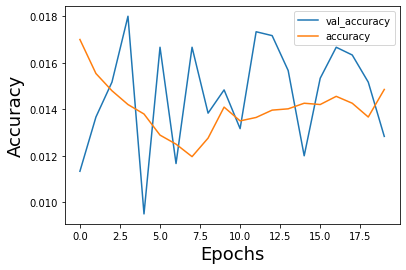

In [104]:
name_title = ['Loss','Accuracy']
# for net in range(nets):
fig=plt.figure(figsize=(64,64))
for i in range(0,2):
    ax=fig.add_subplot(8,8,i+1)
    plt.plot(history.history[list(history.history.keys())[i]], label = list(history.history.keys())[i] )
    plt.plot(history.history[list(history.history.keys())[i+2]],label = list(history.history.keys())[i+2] )
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel(name_title[i], fontsize=18)
    plt.legend()
    plt.show()                                      # model does not perform quite well as seen through the graphs.

In [0]:
test_predict = final_model.predict(X_test)

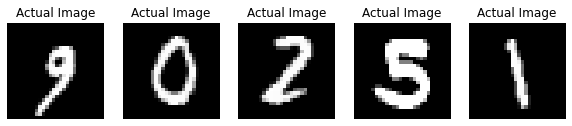

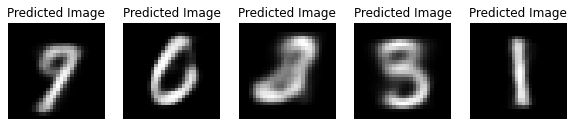

In [106]:
plt.figure(num=1,figsize=(10,8))
for i in range(1000,1005):
  plt.subplot(1,5,i+1-1000)
  plt.imshow(X_test[i].reshape((28,28)),cmap='gray')
  plt.title("Actual Image")
  plt.axis('off')

plt.figure(num=2,figsize=(10,8))
for j in range(1000,1005):
  plt.subplot(1,5,j+1-1000)
  plt.imshow(test_predict[j].reshape((28,28)),cmap='gray')
  plt.title("Predicted Image")
  plt.axis('off')

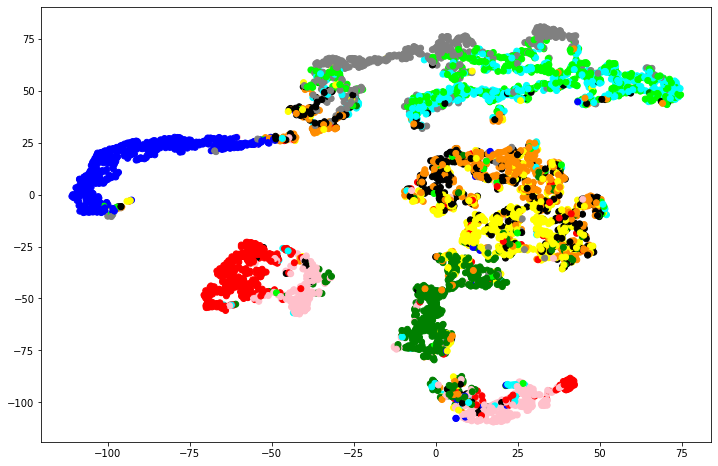

In [115]:
# Dimensionality reduction Visualization
plt.figure(figsize=(12,8))
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,perplexity=40,learning_rate=200.0,n_iter=5000)
X_embedding = tsne.fit_transform(test_predict[:5000])                # taking only first 5000 rows because for larger dataset it takes lot of time.
X_joint = np.hstack((X_embedding,y_test[:5000].reshape(-1,1)))
X_dataFrame = pd.DataFrame(X_joint,columns=['Dimension_1','Dimension_2','Output'])
colors = {0:'red', 1:'blue', 2:'green', 3:'yellow', 4:'aqua', 5:'black', 6:'pink', 7:'gray', 8:'darkorange', 9:'lime'}

plt.scatter(X_dataFrame['Dimension_1'], X_dataFrame['Dimension_2'], c=X_dataFrame['Output'].apply(lambda x: colors[x]))
plt.savefig(fname='Tsne_plots/var_autoEncoder.png',)
plt.show()